# Redfin revisited

In [1]:
%matplotlib notebook
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

import catboost as cgb
import xgboost as xgb
import lightgbm as lgb

### I have pre-processed the redfin data.

keeping only the single family residential houses, filling missing values either 0 for continuous or "unknown" for categorical features, particular the missing values in walkscore, bikescore, and transitscore are filled with mean score for the same zip area. There are two new features created from "property history records", days from last sale, and number of historical records.

In [2]:
redfin = pd.read_csv('redfin_processed.csv',parse_dates=['SOLD DATE'])

In [3]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7314 entries, 0 to 7313
Data columns (total 26 columns):
SOLD DATE              7314 non-null datetime64[ns]
zip                    7314 non-null float64
PRICE                  7314 non-null int64
BEDS                   7314 non-null float64
BATHS                  7314 non-null float64
SQUARE FEET            7314 non-null float64
LOT SIZE               7314 non-null float64
YEAR BUILT             7314 non-null float64
HOA/MONTH              7314 non-null float64
propertyStyle          7314 non-null object
garageCap              7314 non-null int64
parkingCap             7314 non-null int64
driveway               7314 non-null object
roof                   7314 non-null object
patio                  7314 non-null int64
hasPool                7314 non-null object
taxdue                 7314 non-null int64
frontFaceDirection     7314 non-null object
yearRemodled           7314 non-null float64
propertyHistory        7314 non-null object
sc

In [4]:
redfin['propertyHistory'][1000]

"[('Sold (MLS)', 1493362800000), ('Pending', 1491341332920), ('Price Changed', 1489477470000), ('Listed', 1488851879646), ('Delisted', 1195027200000), ('Delisted', 1179173115000), ('Listed', 1179126000000), ('Listed', 1176274800000), ('Sold (MLS)', 947145600000), ('Listed', 945072000000), ('Sold (MLS)', 851328000000), ('Listed', 848908800000)]"

In [5]:
redfin['sold_year'] = redfin['SOLD DATE'].dt.year
redfin['sold_month'] = redfin['SOLD DATE'].dt.month
redfin['sold_day'] = redfin['SOLD DATE'].dt.day

**Since I used property history already, we need to drop it.**

In [6]:
redfin.drop(columns=['propertyHistory','SOLD DATE'],inplace = True)

In [7]:
redfin.head()

,zip,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,propertyStyle,garageCap,...,yearRemodled,schoolserving,walkscore,bikescore,transitscore,days_from_last_sold,n_history,sold_year,sold_month,sold_day
0,84115.0,278000,3.0,2.0,1920.0,4791.0,1919.0,0.0,Bungalow/Cottage,0,...,1919.0,[],70.0,89.0,49.0,0,0,2016,9,23
1,84118.0,154000,2.0,1.0,795.0,7405.0,1950.0,0.0,Rambler/Ranch,0,...,1950.0,[],71.0,61.0,37.0,0,0,2016,9,23
2,84104.0,149734,3.0,2.0,1195.0,10018.0,1906.0,0.0,Rambler/Ranch,0,...,1994.0,"[('Parkview School', 'Preschool to 6', 6), ('G...",50.0,80.0,34.0,3668,21,2016,9,23
3,84118.0,199900,4.0,2.0,1976.0,7840.0,1959.0,0.0,Rambler/Ranch,0,...,1959.0,[],53.0,53.0,37.0,0,0,2016,9,23
4,84124.0,275000,3.0,1.0,1644.0,16988.0,1954.0,0.0,Rambler/Ranch,0,...,1954.0,[],59.0,54.0,38.0,0,0,2016,9,23


In [8]:
redfin.dtypes

zip                    float64
PRICE                    int64
BEDS                   float64
BATHS                  float64
SQUARE FEET            float64
LOT SIZE               float64
YEAR BUILT             float64
HOA/MONTH              float64
propertyStyle           object
garageCap                int64
parkingCap               int64
driveway                object
roof                    object
patio                    int64
hasPool                 object
taxdue                   int64
frontFaceDirection      object
yearRemodled           float64
schoolserving           object
walkscore              float64
bikescore              float64
transitscore           float64
days_from_last_sold      int64
n_history                int64
sold_year                int64
sold_month               int64
sold_day                 int64
dtype: object

## 0. Let define categorical features first

In [9]:
cat_cols = redfin.dtypes[redfin.dtypes=='object'].index.to_list()+['zip']

#### Q1. Define X and y to predict housing price. (1 point)

In [10]:
col1 = redfin.iloc[:, 0]
col2 = redfin.iloc[:, 2:]

X = pd.concat([col1, col2], axis=1)
y = redfin.iloc[:, 1]

#### Q2. Split the data in to 80%/20% train/test, with random_state = 0. (1 point)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8 ,test_size=0.2, random_state=0)

#### Q3. Use label encoding on categorical features, if a feature is new in test, make it as unseen data, with special value of 99999. (6 points)
The encoded data should be named as:

`X_train_lab =
X_test_lab =`

**Hint: see catboost-lightgbm-xgboost notebook 3.3.1**

In [12]:
label_encoder = LabelEncoder()
X_train_lab = X_train.copy()
X_test_lab =  X_test.copy()

for col in cat_cols:
    X_train_lab[col] = label_encoder.fit_transform(X_train_lab[col])
    label_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    X_test_lab[col]=X_test_lab[col].apply(lambda x: label_dict.get(x, 99999))

#### Q4. Use linear regression to fit the model without categorical features. (4 points)
Use: 
> `X_train_lin = X_train[[x for x in X_train.columns if x not in cat_cols]]
X_test_lin = X_test[[x for x in X_test.columns if x not in cat_cols]]`

and calculate root mean squared error (RMSR) and $R^2$. 

To calculate mean squared error and $R^2$, use

> `from math import sqrt
RMSE = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)`

see https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

**Please print out time used for training and RMSE and $R^2$**

**Hint** You can use `%time` in the beginning of the statement, and it will print the time itself.

In [13]:
import numpy as np
%time print('time used for calculating sum of 0 to 100,000,000!:',sum([x for x in range(0,100000001)]))

time used for calculating sum of 0 to 100,000,000!: 5000000050000000
Wall time: 11.1 s


In [14]:
X_train_lin = X_train[[x for x in X_train.columns if x not in cat_cols]]
X_test_lin = X_test[[x for x in X_test.columns if x not in cat_cols]]

regressor = LinearRegression()  
regressor.fit(X_train_lin, y_train)

y_pred = regressor.predict(X_test_lin)
y_true = y_test

from math import sqrt
RMSE = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f'Root Mean Squared Error: {RMSE}')
print(f'R-Squared: {r2}')

# Reference: https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

Root Mean Squared Error: 108801.56087374304
R-Squared: 0.7430084239940704


### Use Xgboost . (18 points)

#### Q5. use `xgb.DMatrix` to define training and test data as: (4 points)

Use `X_train_lab, X_test_lab`

> `dtrain = `

> `dvalid = `

In [15]:
dtrain = xgb.DMatrix(X_train_lab, y_train)
dvalid = xgb.DMatrix(X_test_lab, y_test)

C:\Users\micha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


#### Q6. Setting hyperparameters in `params_xgb`. (2 points)

This is a regression problem, 
+ the first parameter is `"objective"` to be `'reg:squarederror'`.
+ Set 'learning_rate' or 'eta' to 0.2


In [16]:
params_xgb = {
    'objective': 'reg:squarederror',
    'eta': 0.2,
    'eval_metric': 'rmse'
}

#### Q7. Train the model (6 points)
+ model name: model_xgb
+ use 1000 boosting round
+ set evals as [(dtrain,'train'),(dvalid,'valid')]
+ early stopping round is 50
+ verbose_eval is set to 25
+ print training time

In [17]:
%time model_xgb = xgb.train(params_xgb, dtrain, 1000, evals=[(dtrain,'train'),(dvalid,'valid')], early_stopping_rounds=50, verbose_eval=25)
print(model_xgb) # Should this be judged off log loss?

[0]	train-rmse:393786	valid-rmse:370154
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[25]	train-rmse:57495.3	valid-rmse:82290.4
[50]	train-rmse:44168.4	valid-rmse:81194.2
[75]	train-rmse:37198.2	valid-rmse:80919.4
[100]	train-rmse:32820.5	valid-rmse:80481.2
[125]	train-rmse:28631.5	valid-rmse:80840.3
Stopping. Best iteration:
[98]	train-rmse:33207.5	valid-rmse:80444.4

Wall time: 896 ms


#### Q8. Predict on X_test_lab, save prediction in y_pred_xgb. (2 points)

Use `ntree_limit=bst.best_ntree_limit`

In [18]:
y_pred_xgb = model_xgb.predict(dvalid, ntree_limit=model_xgb.best_ntree_limit)
print(y_pred_xgb)

[554121.7  418133.44 219322.48 ... 192750.66 519513.88 883485.4 ]


#### Q9. Print MSE and R squared(2 points)

In [19]:
RMSE_xgb = sqrt(mean_squared_error(y_true, y_pred_xgb))
r2_xgb = r2_score(y_true, y_pred_xgb)

print(f'Root Mean Squared Error: {RMSE_xgb}')
print(f'R-Squared: {r2_xgb}')

Root Mean Squared Error: 80444.43948429578
R-Squared: 0.8595115257246546


#### Q10. Plot feature importance (2 points)

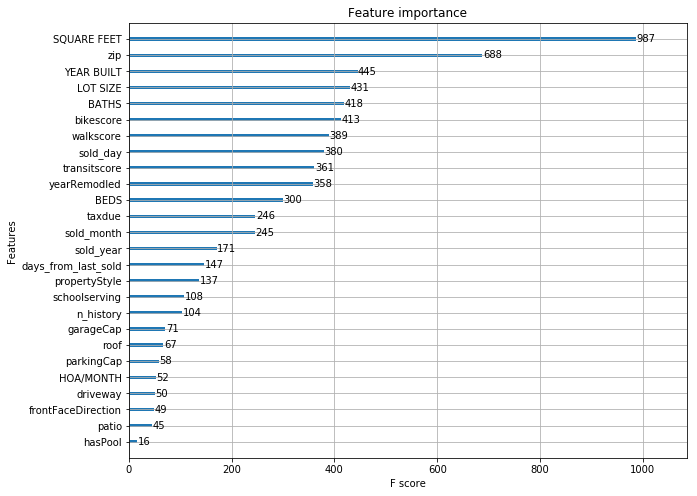

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
xgb.plot_importance(model_xgb)

## Use lightgbm

#### Q11. define training and test data as (2 points)
Use `X_train_lab, X_test_lab`

**Note: Please add "`free_raw_data = False`" in the Dataset().**

> `train_data = `

> `validation_data =`

In [32]:
train_data = lgb.Dataset(X_train_lab, label=y_train, free_raw_data=False)
validation_data = lgb.Dataset(X_test_lab, label=y_test, free_raw_data=False)

#### Q12. Setting model hyperparameters (2 points)

+ parameter name is params_lgb
+ Set 'objective' to 'regression'
+ Set 'learning_rate' to 0.3
+ Set 'metric' to 'mean_squared_error'

In [33]:
params_lgb = {"learning_rate" : 0.3,
             'objective': 'regression',
             'metric':'mean_squared_error'
             }

#### Q13. Train the model without specifying categorical features. (4 points)
+ model name: model_lgb
+ use 10000 boosting round
+ set valid_sets as validation_data
+ early stopping round is 100
+ verbose_eval is set to 100
+ print training time

In [34]:
%time model_lgb = lgb.train(params_lgb, train_set=train_data, num_boost_round=10000, valid_sets=validation_data, early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 7.5962e+09
Early stopping, best iteration is:
[46]	valid_0's l2: 7.33499e+09
Wall time: 265 ms


#### Q14. Predict on X_test_lab, save prediction in y_pred_lgb and print MSE. (2 points)
use num_iteration=model_lgb.best_iteration

In [35]:
y_pred_lgb = model_lgb.predict(X_test_lab, num_iteration = model_lgb.best_iteration)

r2_lgb_1 = r2_score(y_true, y_pred_lgb)
print(f'RMSE: {sqrt(mean_squared_error(y_true, y_pred_lgb))}')  #RMSE or MSE
print(f'R-Squared: {r2_lgb_1}')

RMSE: 85644.54433206395


#### Q15. Re-train the model with specifying categorical features. (2 points)
+ name the model as model_lgb_cat.
+ use 10000 boosting round
+ set valid_sets as validation_data
+ early stopping round is 100
+ verbose_eval is set to 100
+ print training time

In [36]:
%time model_lgb_cat = lgb.train(params_lgb, train_set=train_data, num_boost_round=10000, valid_sets=validation_data, categorical_feature = cat_cols, early_stopping_rounds=100, verbose_eval=100)

C:\Users\micha\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['driveway', 'frontFaceDirection', 'hasPool', 'propertyStyle', 'roof', 'schoolserving', 'zip']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 7.2282e+09
Early stopping, best iteration is:
[24]	valid_0's l2: 6.86648e+09
Wall time: 224 ms


#### Q16. Predict on X_test_lab, save prediction in "y_pred_lgb_cat" and print RMSE and $R^2$. (2 points)
use num_iteration=model_lgb_cat.best_iteration

In [37]:
y_pred_lgb_cat = model_lgb_cat.predict(X_test_lab, num_iteration = model_lgb_cat.best_iteration)

r2_lgb_cat = r2_score(y_true, y_pred_lgb_cat)

print(f'RMSE: {sqrt(mean_squared_error(y_true, y_pred_lgb_cat))}')  #RMSE or MSE
print(f'R-Sqaured: {r2_lgb_cat}')

RMSE: 82864.23784028692
R-Sqaured: 0.8509325176859336


## Use Catboost

### Using label encoding without specifying categorical features.

#### Q17. Define dataset with Pool(). (2 points)
Use `X_train_lab, X_test_lab`

> `train_pool =` 

> `valid_pool = `

In [39]:
from catboost import CatBoost, Pool
train_pool = Pool(X_train_lab, y_train)

valid_pool = Pool(X_test_lab, y_test)

#### Q18. Setting the hyperparameters as params_cgb. (1 point)

+ parameter name is params_cgb.
+ Set 'objective' to 'RMSE'
+ Set 'learning_rate' to 0.02
+ Set 'iterations'  to 2000

In [40]:
params_cgb = { 'objective' : 'RMSE',
              'iterations':2000,
              'learning_rate' : 0.02
             }

#### Q19. Train the model. (2 points)
+ name the model as model_cgb.
+ set eval_set as valid_pool
+ early stopping round is 100
+ verbose_eval is set to 100
+ print training time

In [41]:
model_cgb = CatBoost(params_cgb)

%time model_cgb.fit(train_pool, eval_set=valid_pool,early_stopping_rounds=100,verbose_eval=100)

0:	learn: 242511.8425792	test: 211951.1246688	best: 211951.1246688 (0)	total: 87.2ms	remaining: 2m 54s
100:	learn: 122297.0734733	test: 103902.7547548	best: 103902.7547548 (100)	total: 331ms	remaining: 6.23s
200:	learn: 98628.7677881	test: 92278.3581251	best: 92278.3581251 (200)	total: 551ms	remaining: 4.93s
300:	learn: 88820.2074906	test: 88149.5814561	best: 88149.5814561 (300)	total: 773ms	remaining: 4.36s
400:	learn: 82423.6103526	test: 85584.8349481	best: 85584.8349481 (400)	total: 999ms	remaining: 3.98s
500:	learn: 77107.5083166	test: 83362.4065782	best: 83362.3563972 (497)	total: 1.25s	remaining: 3.75s
600:	learn: 73349.7692819	test: 82049.1164726	best: 82049.1164726 (600)	total: 1.49s	remaining: 3.46s
700:	learn: 69564.3677261	test: 80481.0618694	best: 80481.0618694 (700)	total: 1.72s	remaining: 3.19s
800:	learn: 66481.9111548	test: 79664.6287091	best: 79654.6998144 (798)	total: 1.96s	remaining: 2.94s
900:	learn: 63717.4745935	test: 78875.3295740	best: 78875.3295740 (900)	total:

#### Q20. Predict on valid_pool, save prediction in "y_pred_cgb" and print RMSE and $R^2$. (2 points)
use prediction_type='RawFormulaVal'

In [48]:
y_pred_cgb = model_cgb.predict(valid_pool, prediction_type='RawFormulaVal')

r2_cgb = r2_score(y_true, y_pred_cgb)

print(f'RMSE: {sqrt(mean_squared_error(y_true, y_pred_cgb))}')  #RMSE or MSE
print(f'R-Sqaured: {r2_cgb}')

RMSE: 75652.04159791277
R-Sqaured: 0.8757518470129814


### Using original data and specifying categorical features.

+ We use same parameters set in `params_cgb`.
+ We **do not** define data with Pool, instead, we just supply data when we fit the model.






#### Q21. Change 'zip' feature data type from "float 64" into "int64". (2 points)
Use original data `X_train, X_test` and copy them into

> `X_train_cgb =`

> `X_test_cgb =`

**Note**, categorical features must be eith string or int, however, zip is in float, you need to first conver zip to int!

In [43]:
X_train[cat_cols].dtypes

propertyStyle          object
driveway               object
roof                   object
hasPool                object
frontFaceDirection     object
schoolserving          object
zip                   float64
dtype: object

In [44]:
X_train_cgb = X_train.copy()

X_test_cgb = X_test.copy()

In [45]:
X_train_cgb['zip'] = X_train_cgb['zip'].apply(int)
X_test_cgb['zip'] = X_test_cgb['zip'].apply(int)

#### Q22. Train the model with specifying categorical features. (6 points)

+ name the model as model_cgb_cat 
+ use the same parameters params_cgb
+ inside model_cgb_cat.fit(), set:
   + X=X_train_cgb, 
   + y=y_train, 
   + eval_set = (X_test_cgb,y_test), 
   + cat_features = cat_cols,
   + early_stopping_rounds=100,
   + verbose_eval=100

In [46]:
model_cgb_cat = CatBoost(params_cgb)

#train the model

%time model_cgb_cat.fit(X = X_train_cgb, y = y_train, eval_set = (X_test_cgb, y_test), cat_features = cat_cols, early_stopping_rounds = 100, verbose_eval = 100)

0:	learn: 242485.8482532	test: 211987.5135057	best: 211987.5135057 (0)	total: 32.1ms	remaining: 1m 4s
100:	learn: 115301.9907759	test: 93935.2525651	best: 93935.2525651 (100)	total: 2.44s	remaining: 45.9s
200:	learn: 94108.9818540	test: 85111.6401098	best: 85111.6401098 (200)	total: 5.1s	remaining: 45.7s
300:	learn: 85504.3005795	test: 83064.8027124	best: 83022.2797369 (297)	total: 7.79s	remaining: 44s
400:	learn: 79963.1057565	test: 80984.3253497	best: 80984.3253497 (400)	total: 10.4s	remaining: 41.5s
500:	learn: 75725.1774407	test: 79394.5066816	best: 79394.5066816 (500)	total: 12.8s	remaining: 38.3s
600:	learn: 71873.8694360	test: 77868.3868520	best: 77868.3868520 (600)	total: 15.4s	remaining: 35.8s
700:	learn: 68852.7978592	test: 76722.6954733	best: 76722.6954733 (700)	total: 17.9s	remaining: 33.1s
800:	learn: 66358.6971877	test: 75940.4794753	best: 75940.4794753 (800)	total: 20.4s	remaining: 30.5s
900:	learn: 64266.4094886	test: 75513.6124171	best: 75513.6124171 (900)	total: 23.2s

#### Q23. Predict on X_test_cgb, save prediction in "y_pred_cgb_cat" and print RMSE and $R^2$. (2 points)
use prediction_type='RawFormulaVal'

In [54]:
y_pred_cgb_cat =  model_cgb_cat.predict(X_test_cgb, prediction_type='RawFormulaVal')

r2_cgb = r2_score(y_true, y_pred_cgb_cat)

print(f'RMSE: {sqrt(mean_squared_error(y_true, y_pred_cgb_cat))}')  #RMSE or MSE
print(f'R-Sqaured: {r2_cgb}')

RMSE: 73841.11094395407
R-Sqaured: 0.8816290644269236


#### Q24. Compare the results of all the models. (2 points)

Here are my results, you do not have to be exactly the same to get full credits, the random seeds may be different, the big picture should be the same though. 

You dont have to construct the results in tables in this notebook, the easiest way is to copy the results to excel or word, and then take a screenshot and past it here.

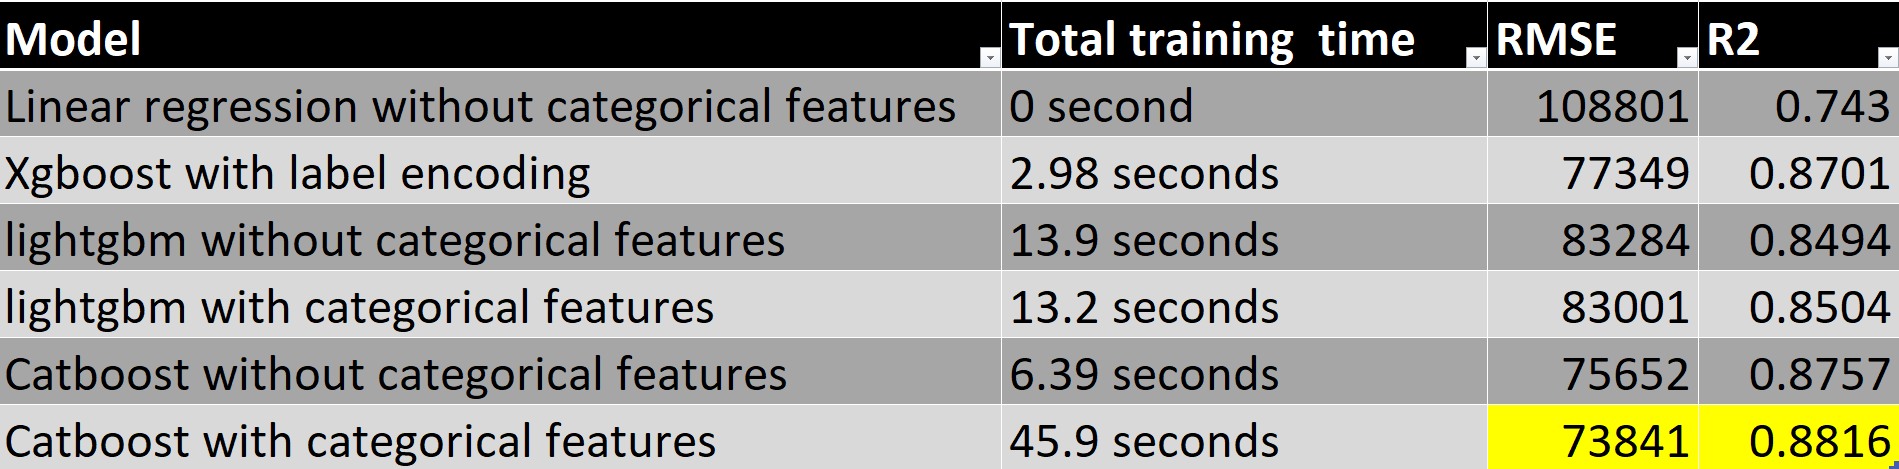

## What's next?

This notebook only demonstrates the simple syntax of regression with Xgboost, lightgbm, and Catboost without any tunning of hyperparameters or cross validations. However, this serves as a starting point for you to learn about these three algorithms and you can al least run the basic models!

Going further, you could:
+ Check the documentations to see other available hyperparameters and play with them.
+ Try using cross validation to make the model more reliable.
+ Use grid search and trying to find the better models.
+ Going back to the dataset, and do the data preprocssing yourselves, and see if you can create more features and try training different models again.
+ Search online for more examples of using these algorithms, and you will see there are much more to learn!!!